# Use Xarray Interp to create Lat/Lon Corner Variables so we can use Conservative Regridding

In [1]:
import numpy as np
import xarray as xr
import xesmf
# https://github.com/raphaeldussin/HCtFlood
from HCtFlood import kara as flood
import sys
import numpy as np
import xarray
import os.path

era5_dict = {'ERA5_2m_temperature':'t2m',
             'ERA5_sea_ice_cover':'siconc',
            'ERA5_10m_u_component_of_wind':'u10',
            'ERA5_sea_surface_temperature':'sst',
            'ERA5_10m_v_component_of_wind':'v10',
            'ERA5_surface_solar_radiation_downwards':'ssrd',
            'ERA5_surface_thermal_radiation_downwards':'strd',
            'ERA5_total_rain_rate':'trr',
            'ERA5_mean_sea_level_pressure':'msl',
            'ERA5_2m_specific_humidity':'q2'}

def interp_landmask(landmask_file):
    landmask = xr.open_dataset(landmask_file).rename({'x': 'lon', 'y': 'lat'})
    lon_centers = landmask['lon'].values
    lat_centers = landmask['lat'].values

    lon_corners = 0.25 * (
        lon_centers[:-1, :-1]
        + lon_centers[1:, :-1]
        + lon_centers[:-1, 1:]
        + lon_centers[1:, 1:]
    )

    # have to add 2 extra rows/columns to the array becuase we remove 1 when we calculate the corners from the center values
    lon_corners_exp = np.full((lon_corners.shape[0]+2,lon_corners.shape[1]+2),np.nan)
    lon_corners_exp[:-2,:-2] = lon_corners
    landmask['lon_b'] = xr.DataArray(data=lon_corners_exp, dims=("nyp", "nxp"))
    lon_b = landmask['lon_b']
    filled = lon_b.interpolate_na(dim='nyp',method='linear',fill_value="extrapolate")
    filled_lon = filled.interpolate_na(dim='nxp',method='linear',fill_value="extrapolate")
    
    # interpolate latitidue corners from latitude cell centers
    lat_corners = 0.25 * (
        lat_centers[:-1, :-1]
        + lat_centers[1:, :-1]
        + lat_centers[:-1, 1:]
        + lat_centers[1:, 1:]
    )

    # create expanded latitude corners array and then interpolate the values so our nxp, nyp = nx+1, ny+1
    lat_corners_exp = np.full((lat_corners.shape[0]+2,lat_corners.shape[1]+2),np.nan)
    lat_corners_exp[:-2,:-2] = lat_corners
    landmask['lat_b'] = xr.DataArray(data=lat_corners_exp, dims=("nyp", "nxp"))
    lat_b = landmask['lat_b']
    filled= lat_b.interpolate_na(dim='nyp',method='linear',fill_value="extrapolate")
    filled_lat = filled.interpolate_na(dim='nxp',method='linear',fill_value="extrapolate")
    landmask['lon_b'] = filled_lon
    landmask['lat_b'] = filled_lat
    landmask['mask'] = landmask['mask'].where(landmask['mask'] != 1)
    
    return landmask
    
    
def interp_era5(era5_file, era5_var):
    era = xr.open_dataset(era5_file)
    era = era.rename({'longitude': 'lon', 'latitude': 'lat'})
    if "lon" in era.coords:
        era = era.assign_coords(lon=(np.where(era['lon'].values > 180., era['lon'].values - 360, era['lon'].values)))
        era = era.swap_dims({'lon' : 'nx'})    
        era = era.swap_dims({'lat' : 'ny'}) 
    if "lon" in era.data_vars:
        era['lon'].values =  np.where(era['lon'].values > 180., era['lon'].values - 360, era['lon'].values)

    lon_centers = era['lon'].values
    lat_centers = era['lat'].values
    # To use conservative regidding, we need the cells corners. 
    # Since they are not provided, we are creating some using a crude approximation. 
    lon_corners = 0.25 * (
        lon_centers[:-1]
        + lon_centers[1:]
        + lon_centers[:-1]
        + lon_centers[1:]
    )

    lat_corners = 0.25 * (
        lat_centers[:-1]
        + lat_centers[1:]
        + lat_centers[:-1]
        + lat_centers[1:]
    )

    # trim down era by 1 cell
    era = era.isel(nx=slice(1,-1), ny=slice(1,-1))
    da_era_var=era[era5_var].values

    # add nxp and nyp dimensions for the lat/lon corners to latch onto
    era = era.expand_dims({'nyp':(len(era.lat) + 1)})
    era = era.expand_dims({'nxp':(len(era.lon) + 1)})

    # add the lat/lon corners as data variables, flip latitude rightside up
    era['lat_corners'] = xr.DataArray(data=lat_corners, dims=("nyp"))
    era['lon_corners'] = xr.DataArray(data=lon_corners, dims=("nxp"))
    # drop the variable

    era = era.drop_vars(era5_var)
    # replace the variable
    era[era5_var] = xr.DataArray(data=da_era_var, dims=("time", "lat", "lon"))
    
    # create meshgrids for center and corner points so we can co-locate with landmask meshgrids.
    lon2d, lat2d = np.meshgrid(era.lon.values, era.lat.values)
    lon2d_b, lat2d_b = np.meshgrid(era.lon_corners.values, era.lat_corners.values)
    
    # assign coordinates now that we have our corner points
    era = era.assign_coords({"lon" : (("ny", "nx"), lon2d)})
    era = era.assign_coords({"lat" : (("ny", "nx"), lat2d)})
    era = era.assign_coords({"lon_b" : (("nyp", "nxp"), lon2d_b)})
    era = era.assign_coords({"lat_b" : (("nyp", "nxp"), lat2d_b)})
    
    return era

In [6]:
landmask_file="/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/nwa25/land_mask.nc"
era5_file="/Users/james/Downloads/ERA5_2m_temperature_1996.nc"
era5_var="t2m"


landmask = interp_landmask(landmask_file)

#interp era
era = interp_era5(era5_file, era5_var)

# regrid conservatively: conservative does the best, especially along fine points
regrid_domain = xesmf.Regridder(landmask, era, 'conservative', 
                                periodic=False, reuse_weights=True, filename='regrid_domain.nc')
land_regrid = regrid_domain(landmask.mask)

land_regrid = regrid_domain(landmask.mask)
land_regrid=land_regrid.expand_dims(time=era['time'])
land_regrid=land_regrid.transpose("time", "ny", "nx")
#print(land_regrid)
era=era.transpose("time", "lat", "lon", "ny", "nx", "nyp", "nxp")
# cut era based on regridded landmask
era_cut = era[era5_var].where(land_regrid.values == 0)


### Use Landmask from Ocean Grid on the points we need to flood

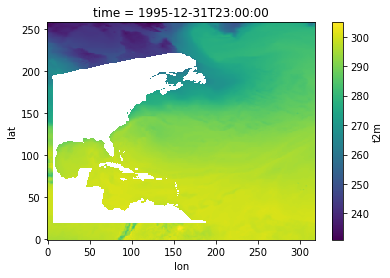

In [7]:
era_cut[0].plot()

In [8]:

# flood our cut out points
flooded = flood.flood_kara(era_cut)
flooded = flooded.isel(z=0).drop('z')
#print(flooded)
# note that this current version of this code will cut down your era5 domain by 2 rows/colse)
era = xr.open_dataset(era5_file)
era = era.isel(longitude=slice(1,len(era.longitude)-1), latitude=slice(1,len(era.latitude)-1))
era=era.transpose("time", "latitude", "longitude")
#fprint(era)
era[era5_var].values = flooded.values

### Flooded Temperature

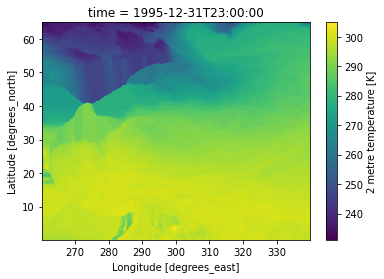

In [9]:
era.t2m[0].plot()

### Original Temperature

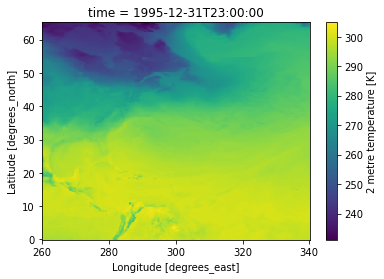

In [10]:
xr.open_dataset(era5_file).t2m[0].plot()

### Difference

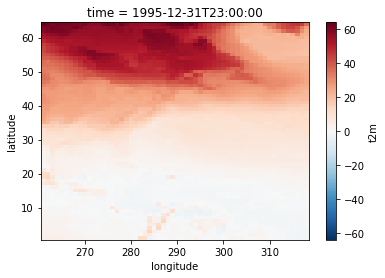

In [11]:
diff = flooded[0].rename({'lat':'latitude', 'lon':'longitude'}) - xr.open_dataset(era5_file).isel(latitude=slice(1, len(era.latitude)+1), longitude=slice(1,len(era.longitude)+1)).t2m[0]
diff.plot()